In [1]:
import subprocess
import time
subprocess.check_output(["maturin", "develop"])

🍹 Building a mixed python/rust project
🔗 Found pyo3 bindings
🐍 Found CPython 3.10 at /home/wint3rmute/code/luthier/.venv/bin/python
📡 Using build options features from pyproject.toml
   Compiling pyo3-build-config v0.18.3
   Compiling pyo3-ffi v0.18.3
   Compiling pyo3 v0.18.3
   Compiling numpy v0.18.0
   Compiling luthier v0.1.0 (/home/wint3rmute/code/luthier)
    Finished dev [unoptimized + debuginfo] target(s) in 9.43s
📦 Built wheel for CPython 3.10 to /tmp/.tmpSGueoY/luthier-0.1.0-cp310-cp310-linux_x86_64.whl
🛠 Installed luthier-0.1.0


b''

In [11]:
import numpy as np
import audioflux as af
from audioflux.type import SpectralFilterBankScaleType
from IPython.display import Audio, display, Image, HTML
import matplotlib.pyplot as plt
from audioflux.display import fill_spec
import PIL
from tqdm.notebook import trange, tqdm
from copy import deepcopy
from IPython.display import clear_output
import librosa
from scipy.optimize import differential_evolution
import soundfile as sf
from multiprocessing import Pool
import os
from luthier.luthier import DspGraph, SineOscillator, Multiplier, HarmonicMultiplier
from luthier.dsp import Sample
plt.rcParams['figure.dpi'] = 110
SAMPLE_RATE = 22050

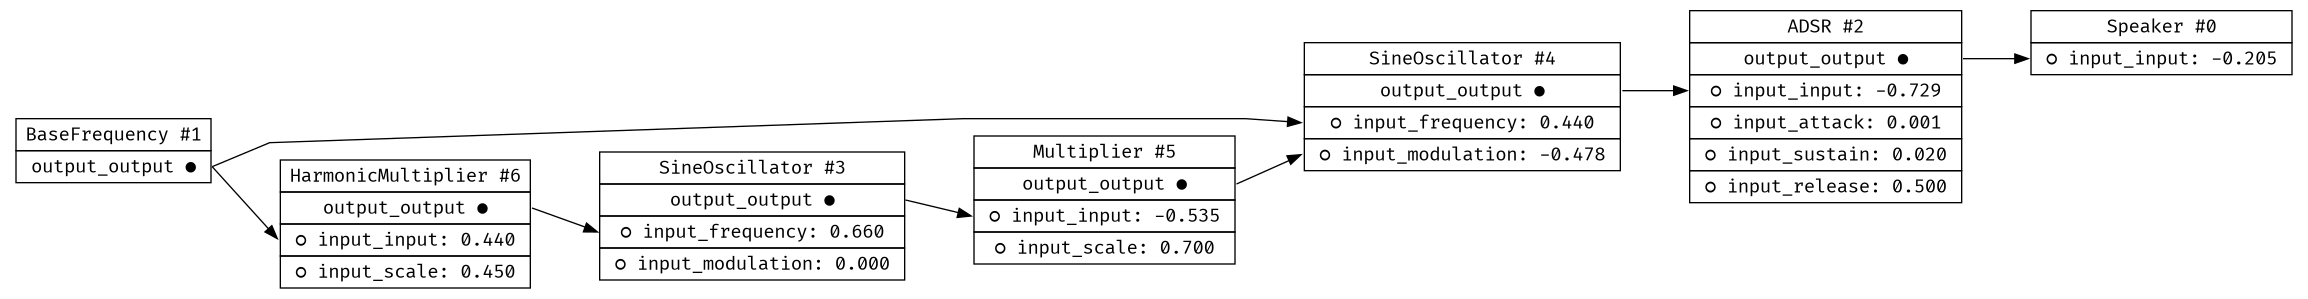

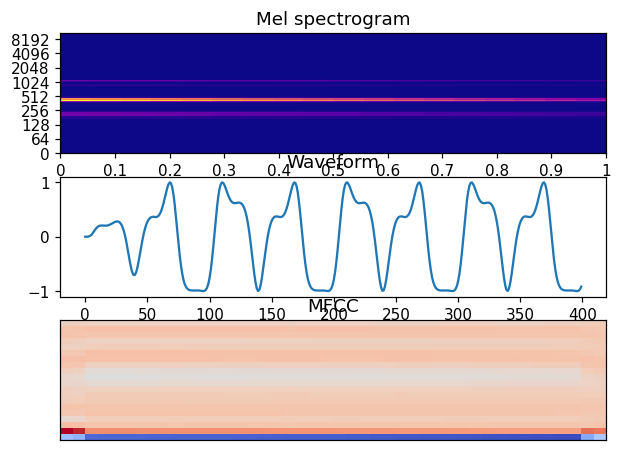

In [47]:
def one_operator_fm():
    graph = DspGraph()

    modulator = graph.add_sine(SineOscillator())
    _carrier = SineOscillator()
    # _carrier.inputs.modulation_index = 0.05
    carrier = graph.add_sine(_carrier)
    
    mod_index_scaler = graph.add_multiplier(Multiplier())
    mod_freq_mult = graph.add_harmonic_multiplier(HarmonicMultiplier())
    
    graph.set_input(mod_index_scaler, "input_scale", 0.70)
    graph.set_input(mod_freq_mult, "input_scale", 0.45)
    graph.set_input(graph.amp_adsr_node_id , "input_attack", 0.001)
    graph.set_input(graph.amp_adsr_node_id , "input_sustain", 0.02)
    graph.set_input(graph.amp_adsr_node_id , "input_release", 0.5)
    
    graph.patch(carrier, "output_output", 2, "input_input")
    graph.patch(graph.base_frequency_node_id, "output_output", carrier, "input_frequency")
    graph.patch(graph.base_frequency_node_id, "output_output", mod_freq_mult, "input_input" )
    graph.patch(mod_freq_mult, "output_output", modulator, "input_frequency")
    graph.patch(modulator, "output_output", mod_index_scaler, "input_input")
    graph.patch(mod_index_scaler, "output_output", carrier, "input_modulation")
    
    return graph

target_graph = one_operator_fm()

target_audio = Sample(target_graph.play(num_samples = SAMPLE_RATE))
display(Image(target_graph.draw()))

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=False, sharey=False)
target_audio.plot_spectrogram(ax1)
target_audio.plot_waveform(ax2)
target_audio.plot_mfcc(ax3)
target_audio.show_player()

  0%|          | 0/21 [00:00<?, ?it/s]

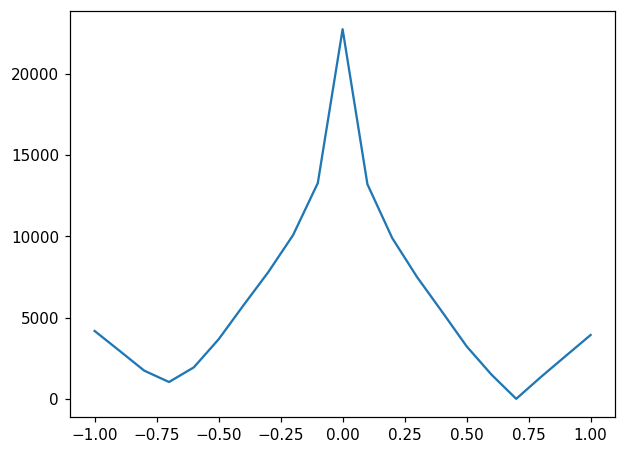

In [49]:
mod_strengths = [ a / 100 for a in range(-100, 101, 10) ]
# results = []

def get_distance_variable_mod_strength(strength):
    graph = one_operator_fm()
    graph.set_input(5, "input_scale", strength)
    generated_audio = Sample(graph.play(SAMPLE_RATE))
    dist = target_audio.mfcc_distance(generated_audio)
    return dist

with Pool() as p:
    results = list(tqdm(p.imap(get_distance_variable_mod_strength, mod_strengths), total=len(mod_strengths)))

plt.plot( mod_strengths, results )

  0%|          | 0/20 [00:00<?, ?it/s]

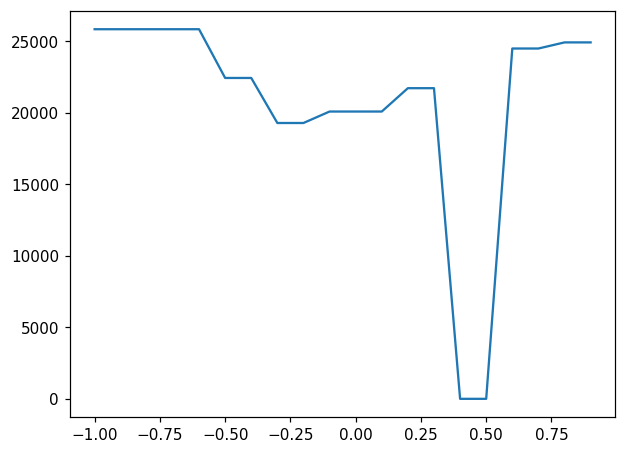

In [51]:
mod_freqs = [ a / 100 for a in range(-100, 100, 10) ]
results = []

def get_distance_variable_mod_freq(freq):
    graph = one_operator_fm()
    graph.set_input(6, "input_scale", freq)
    generated_audio = Sample(graph.play(SAMPLE_RATE))
    dist = target_audio.mfcc_distance(generated_audio)
    return dist

with Pool() as p:
    results = list(tqdm(p.imap(get_distance_variable_mod_freq, mod_freqs), total=len(mod_freqs)))
    
plt.plot( mod_freqs, results )

  0%|          | 0/200 [00:00<?, ?it/s]

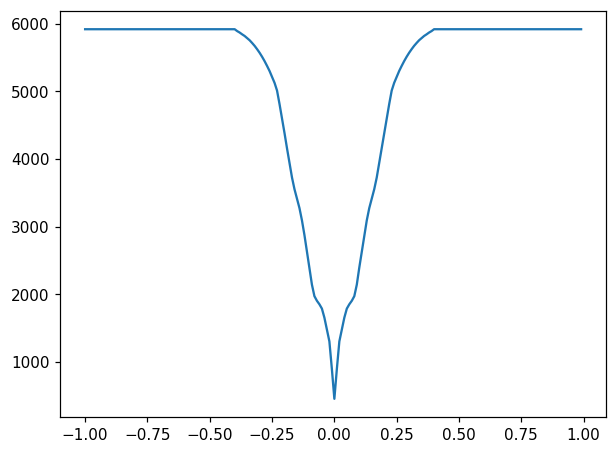

In [54]:
attack_values = [ a / 100 for a in range(-100, 100, 1) ]
results = []

def get_distance_variable_attack(attack):
    graph = one_operator_fm()
    graph.set_input(graph.amp_adsr_node_id, "input_attack", attack)
    generated_audio = Sample(graph.play(SAMPLE_RATE))
    dist = target_audio.mfcc_distance(generated_audio)
    return dist

with Pool() as p:
    results = list(tqdm(p.imap(get_distance_variable_attack, attack_values), total=len(attack_values)))

plt.plot(attack_values, results)

  0%|          | 0/121 [00:00<?, ?it/s]

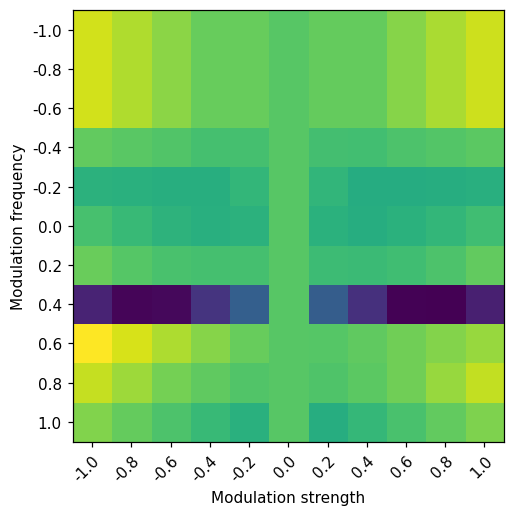

In [55]:
STEP_VALUE = 20 # Lover means better resolution
mod_freqs = [ a / 100 for a in range(-100, 101, STEP_VALUE) ] 
mod_strengths = [ a / 100 for a in range(-100, 101, STEP_VALUE) ] 

test_cases = []
for freq_index, freq in enumerate(mod_freqs):
    for mod_index, mod_strength in enumerate(mod_strengths):    
        test_cases.append( ( (freq_index, freq), (mod_index, mod_strength) ) )

def get_distance_variable_mod_strength(test_case):
    (freq_index, freq), (mod_index, mod_strength) = test_case
    graph = one_operator_fm()

    graph.set_input(6, "input_scale", freq)
    graph.set_input(5, "input_scale", mod_strength)
    generated_audio = Sample(graph.play(SAMPLE_RATE * 1))

    dist = target_audio.mfcc_distance(generated_audio)
    
    return freq_index, mod_index, dist
    
with Pool() as p:
    pool_results = list(tqdm(p.imap(get_distance_variable_mod_strength, test_cases), total=len(test_cases)))  
    
results = np.zeros((len(mod_freqs), len(mod_strengths)))

for pool_result in pool_results:
    freq_index, mod_index, dist = pool_result
    results[freq_index][mod_index] = dist
    
fig, ax = plt.subplots()
im = ax.imshow(results)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(mod_strengths)), labels=mod_strengths)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
ax.set_yticks(np.arange(len(mod_freqs)), labels=mod_freqs)
ax.set_ylabel("Modulation frequency")
ax.set_xlabel("Modulation strength")
fig.tight_layout()